# Analytics - reference-only analysis

In [28]:
import scvi
from scvi.criticism import PosteriorPredictiveCheck as PPC
from ppc_plot_utils import PPCPlot
import anndata
import pandas as pd
import scanpy as sc
import gc
import matplotlib.pyplot as plt
import mplscience
from pathlib import Path
from scvi.data._download import _download
from scvi.data import cellxgene
import os
from scvi.model.base import ArchesMixin
import warnings
from sparse import SparseArray
from typing import Optional

scvi.settings.seed = 0

# plotting commands for the styling
# sns.reset_orig()
mplscience.set_style(reset_current=True, name="default")

%load_ext autoreload
%autoreload 2

Global seed set to 0


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1️⃣ Load the model and raw data

Here we use the HLCA dataset.

Sikkema, L., Ramírez-Suástegui, C., Strobl, D.C. et al. An integrated cell atlas of the lung in health and disease. Nat Med 29, 1563–1577 (2023). https://doi.org/10.1038/s41591-023-02327-2

Let's download the pre-trained model

In [40]:
local_dir = "/Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HLCA"

In [41]:
model_url = "https://huggingface.co/scvi-tools/human-lung-cell-atlas/resolve/main/model.pt"
_download(model_url, local_dir, "model.pt")

INFO     File /Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HLCA/model.pt already downloaded    


Download the raw counts:

In [42]:
def get_hlca_core_adata_cellxgene():
    adata_url = "https://cellxgene.cziscience.com/e/066943a2-fdac-4b29-b348-40cede398e4e.cxg/"
    # takes ~2min to load if data already downloaded
    adata = cellxgene(adata_url, filename="adata.h5ad", save_path=local_dir)

    # get unnormalized, raw counts
    adata.X = adata.raw.X
    del adata.raw
    gc.collect()

    # filter to highly variable genes
    _, mvars, _, _ = scvi.model.base._utils._load_saved_files(local_dir, load_adata=False)
    adata = adata[:, adata.var.index.isin(mvars)].copy()

    # get rid of some var columns that we dont need -- will make later processing easier
    del adata.var["feature_is_filtered"]
    del adata.var["feature_reference"]
    del adata.var["feature_biotype"]

    # 4 genes are missing from cellxgene that are in the model. prepare_query_anndata will pad them with zeros.
    ArchesMixin.prepare_query_anndata(adata, local_dir)

    # add feature_names for the padded genes
    gene_ids = ['ENSG00000253701', 'ENSG00000269936', 'ENSG00000274961', 'ENSG00000279576']
    feature_names = ['AL928768.3', 'RP11-394O4.5', 'RP3-492J12.2', 'AP000769.1']
    adata.var["feature_name"] = adata.var["feature_name"].cat.add_categories(feature_names)
    for g,f in zip(gene_ids, feature_names):
        adata.var.loc[g, "feature_name"] = f

    return adata

# To print the 4 missing genes from adata run this 👇
# bdata = anndata.read_h5ad(os.path.join(local_dir, "adata.h5ad"), backed=True) # downloaded from cellxgene
# _, mvars, _, _ = scvi.model.base._utils._load_saved_files(local_dir, load_adata=False)
# a = list(mvars)
# b = list(adata.var[adata.var.index.isin(mvars)].index)
# diffs = [e for e in a if e not in b]
# print(diffs)

In [43]:
adata = get_hlca_core_adata_cellxgene()

INFO     File /Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HLCA/model.pt already downloaded    
INFO     File /Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HLCA/model.pt already downloaded    
INFO     Found 99.8% reference vars in query data.                                                                 


/Users/valehvpa/GitRepos/scvi-tools/scvi/model/base/_archesmixin.py:225: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_padding = AnnData(


Finally, load the model.

In [45]:
model = scvi.model.SCANVI.load(local_dir, adata = adata, accelerator="cpu")

INFO     File /Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HLCA/model.pt already downloaded    


/Users/valehvpa/GitRepos/scvi-tools/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 18 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/Users/valehvpa/GitRepos/scvi-tools/scvi/data/fields/_scanvi.py:58: UserWarning: Category 18 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(


## 2️⃣ Goodness of fit with PPC + CV

In [7]:
# run ppc+cv
# expected runtime ~5min
models_dict = {"SCANVI": model}
ppc = PPC(model.adata, models_dict, n_samples=2)

In [8]:
# expected runtime ~8min
ppc.coefficient_of_variation("features")

In [11]:
temp_fig_dir = "/Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/temp_figs"

model=SCANVI | metric=cv_cell | n_cells=584944:
Mean Absolute Error=1.56,
Pearson correlation=0.92
Spearman correlation=0.83
r^2=0.84



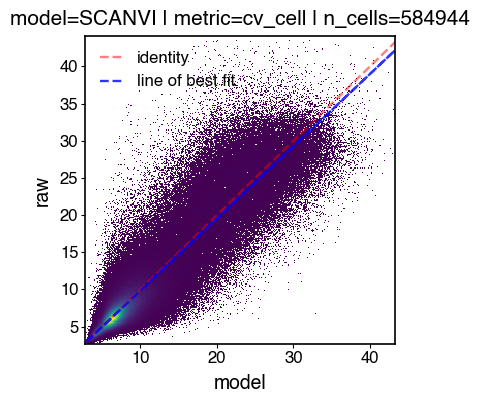

In [13]:
ppc_plt = PPCPlot(ppc)
ppc_plt.plot_cv(model_name="SCANVI", cell_wise=True, plt_type="hist2d")

fig_path = f'{temp_fig_dir}/ppc_cv_cell.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")

## 3️⃣ Goodness of fit with PPC + DE

In [7]:
# run ppc+DE
models_dict = {"SCANVI": model}
ppc = PPC(model.adata, models_dict, n_samples=2)

In [8]:
# expected runtime <1min
ppc.differential_expression(de_groupby="ann_level_3", p_val_thresh=0.2)

In [9]:
ppc.metrics["diff_exp"]["summary"]

,gene_overlap_f1,lfc_mae,lfc_pearson,lfc_spearman,roc_auc,pr_auc,group,model
0,0.96,1.240126,0.673039,0.885598,0.167699,0.95358,AT1,SCANVI
1,0.96,0.285104,0.889135,0.975715,0.17308,0.989185,AT2,SCANVI
2,0.95,0.824867,0.717735,0.925106,0.238711,0.957806,B cell lineage,SCANVI
3,0.98,0.254305,0.927412,0.992829,0.302258,0.985052,Basal,SCANVI
4,0.93,0.560664,0.741447,0.962608,0.332943,0.956947,Dendritic cells,SCANVI
5,0.96,1.110001,0.752002,0.943639,0.274335,0.96683,EC arterial,SCANVI
6,0.98,0.727012,0.804466,0.966579,0.253424,0.984906,EC capillary,SCANVI
7,0.95,0.714444,0.770151,0.953337,0.257222,0.964757,EC venous,SCANVI
8,0.92,0.395069,0.900337,0.981664,0.289017,0.973085,Fibroblasts,SCANVI
9,0.95,0.623261,0.828597,0.96054,0.266632,0.975008,Innate lymphoid cell NK,SCANVI


Plot the summary results

/Users/valehvpa/GitRepos/scvi-hub-reproducibility/ppc_plot_utils.py:194: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.stripplot(model_de_metrics, size=4, color=".3", linewidth=1, palette=sns.color_palette("pastel"))


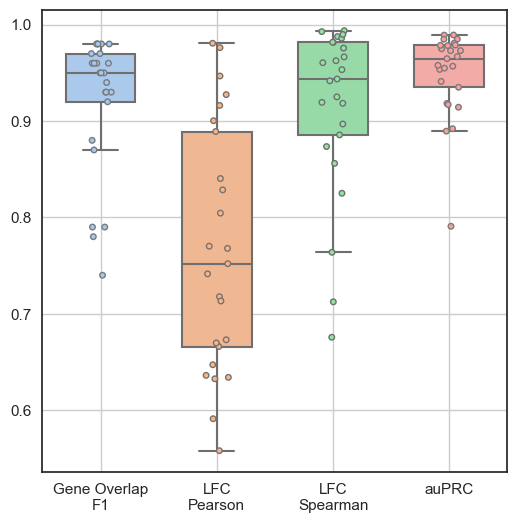

In [13]:
ppc_plt = PPCPlot(ppc)
ppc_plt.plot_diff_exp(
    "SCANVI",
    plot_kind="summary_box_with_obs",
)
fig_path = f'{temp_fig_dir}/de_summary_violin.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

Plot per-group LFC scatterplots.

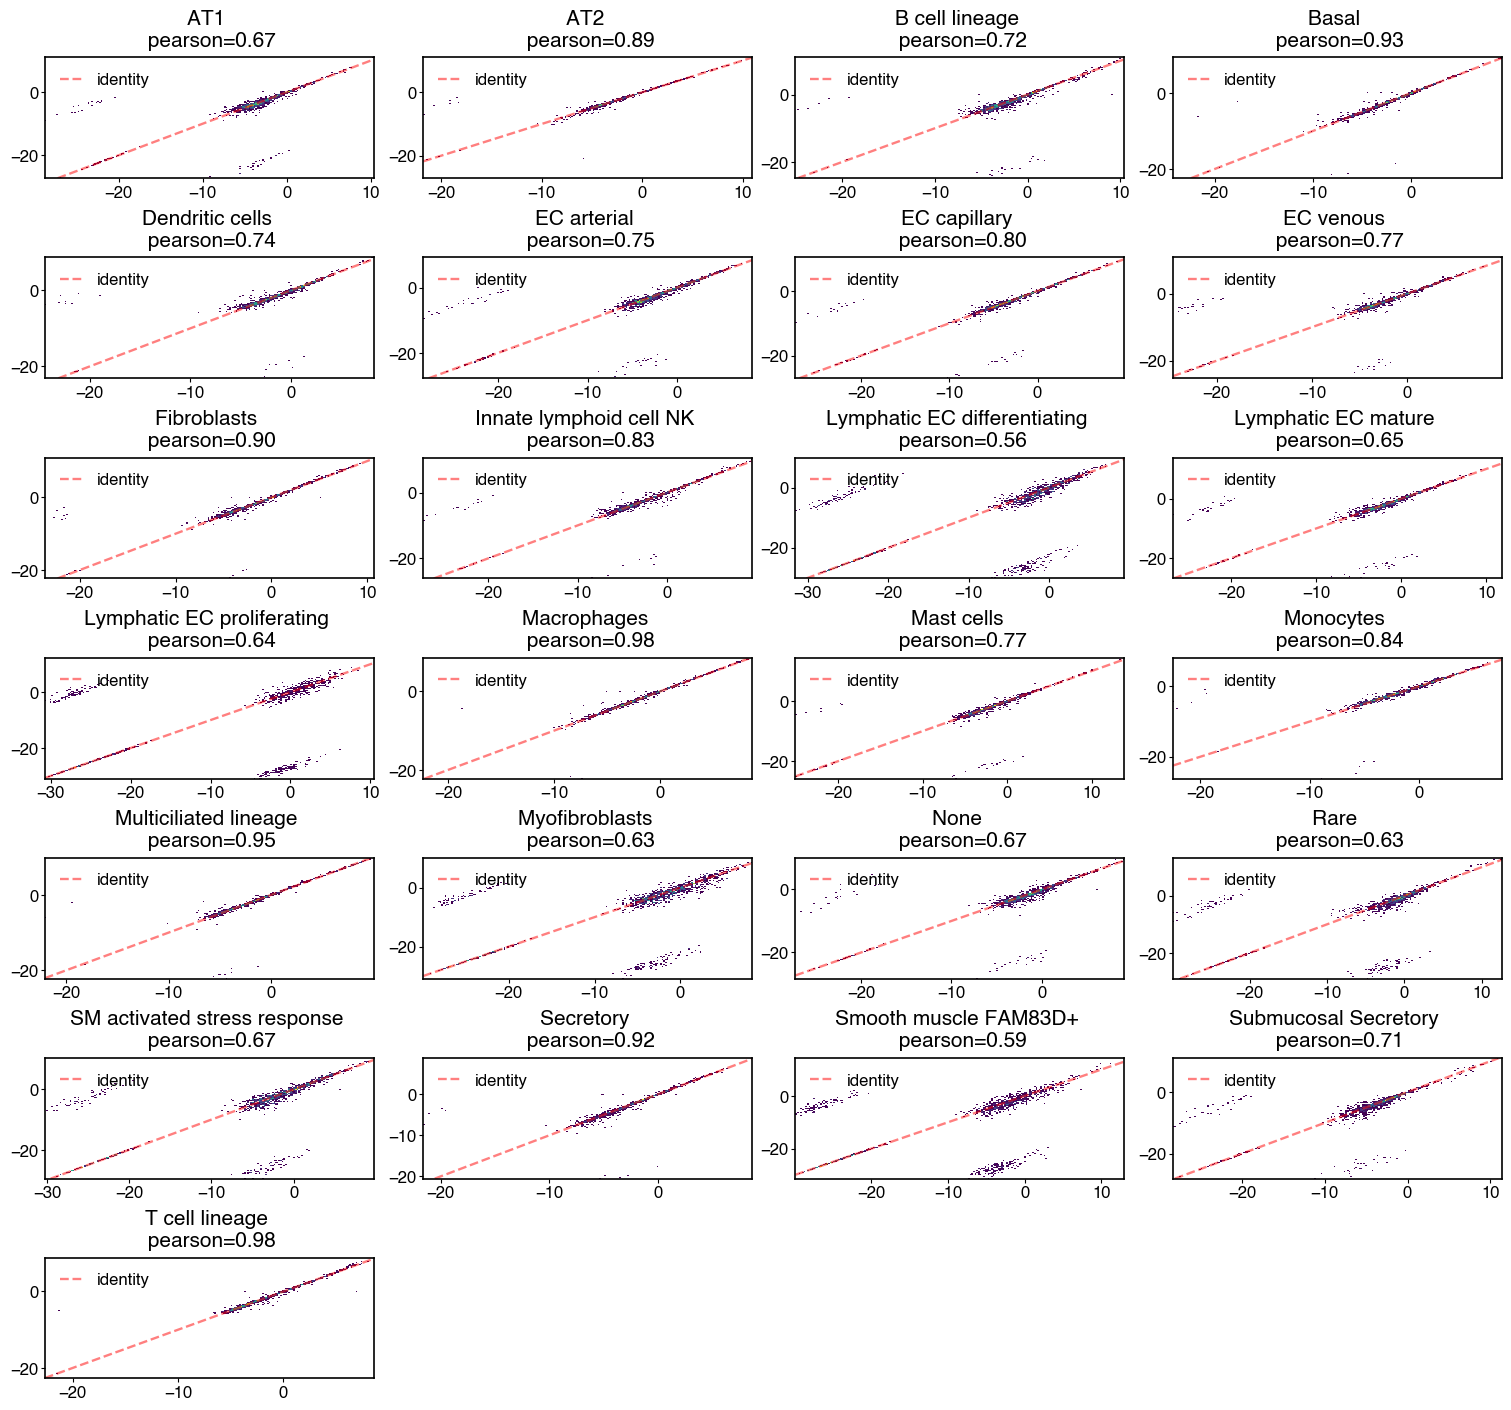

In [12]:
ppc_plt = PPCPlot(ppc)
ppc_plt.plot_diff_exp(
    "SCANVI",
    plot_kind="lfc_scatterplots",
)
fig_path = f'{temp_fig_dir}/de_per_group_lfc_scatter.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

Let's plot the LFC dotplots.

In [14]:
ppc

--- Posterior Predictive Checks ---
n_samples = 2
raw_counts shape = (584944, 2000)
models: ['SCANVI']
metrics: 
{
    "diff_exp": {
        "lfc_per_model_per_group": {
            "SCANVI": {
                "AT1": "Pandas DataFrame with shape=(2000, 2), columns=['raw', 'approx']",
                "AT2": "Pandas DataFrame with shape=(2000, 2), columns=['raw', 'approx']",
                "B cell lineage": "Pandas DataFrame with shape=(2000, 2), columns=['raw', 'approx']",
                "Basal": "Pandas DataFrame with shape=(2000, 2), columns=['raw', 'approx']",
                "Dendritic cells": "Pandas DataFrame with shape=(2000, 2), columns=['raw', 'approx']",
                "EC arterial": "Pandas DataFrame with shape=(2000, 2), columns=['raw', 'approx']",
                "EC capillary": "Pandas DataFrame with shape=(2000, 2), columns=['raw', 'approx']",
                "EC venous": "Pandas DataFrame with shape=(2000, 2), columns=['raw', 'approx']",
                "Fibroblasts":

Plot for the raw counts

In [31]:
adata_de = anndata.AnnData(X=ppc.raw_counts.to_scipy_sparse().tocsr().copy(), obs=ppc.adata.obs, var=ppc.adata.var)
sc.pp.normalize_total(adata_de, target_sum=1e4)
sc.pp.log1p(adata_de)
with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
    sc.tl.rank_genes_groups(adata_de, "ann_level_3", use_raw=False, method="t-test")

/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub-clone/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


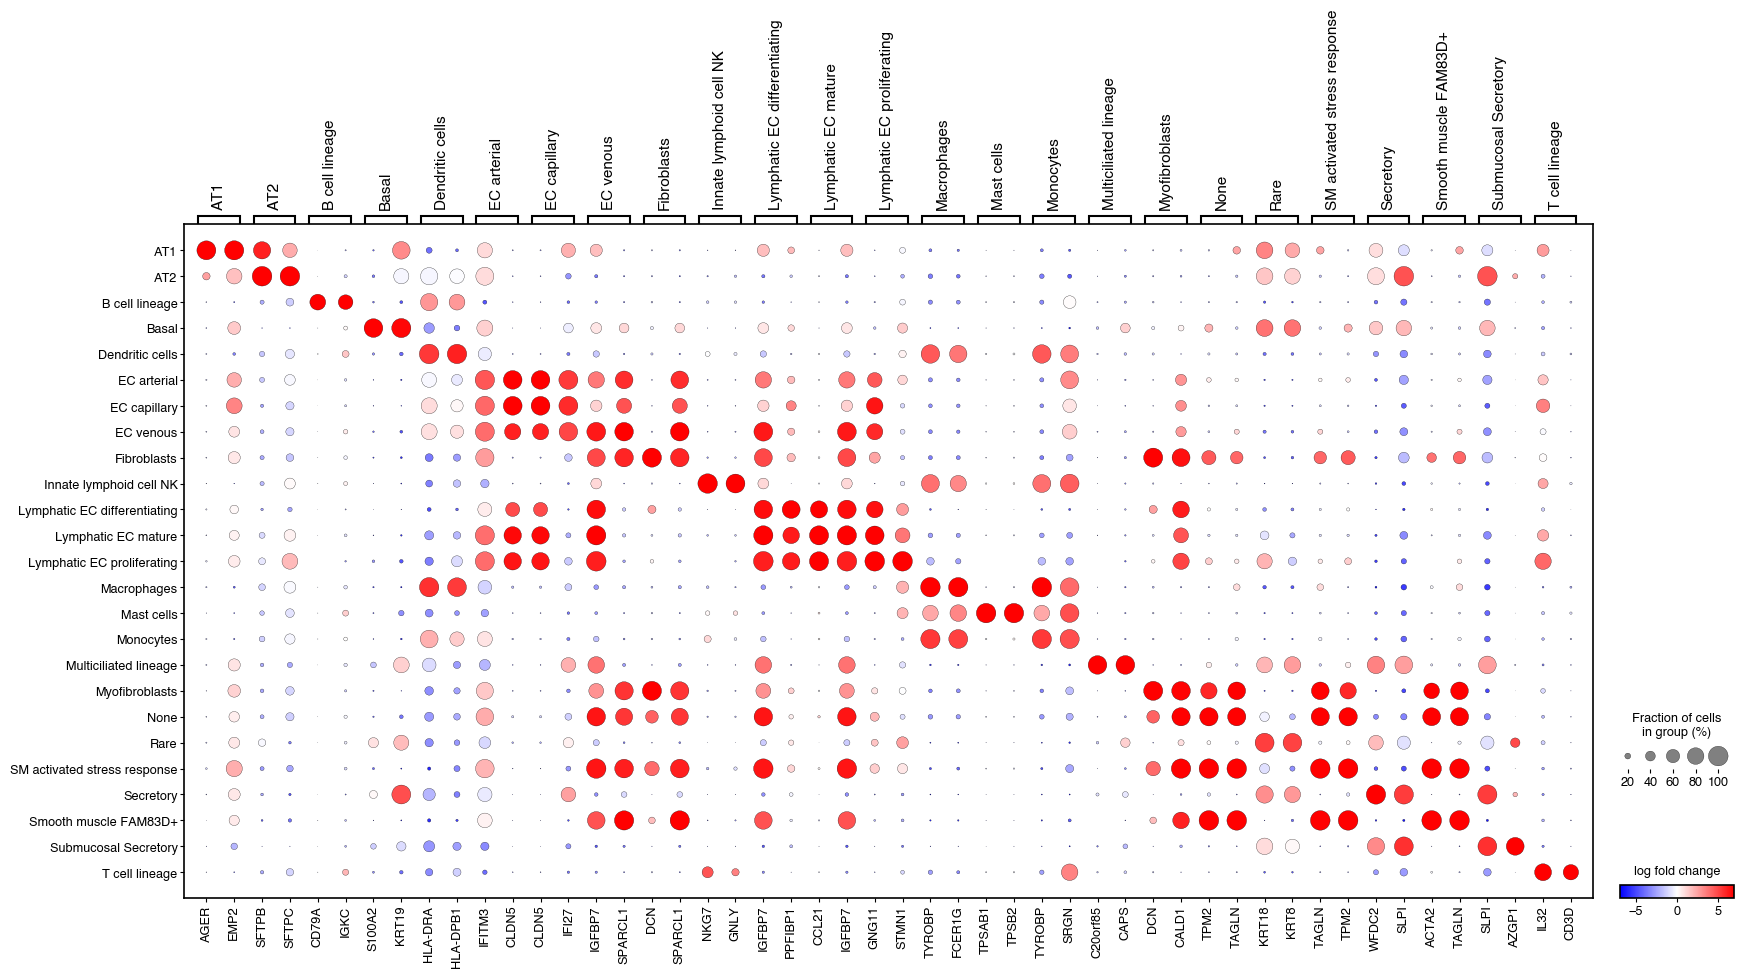

PosixPath('/Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/temp_figs/raw.svg')

In [32]:
fig_name = "raw.svg"
sc.pl.rank_genes_groups_dotplot(
    adata_de,
    values_to_plot="logfoldchanges",
    vmax=7,
    vmin=-7,
    cmap="bwr",
    dendrogram=False,
    gene_symbols="feature_name",
    n_genes=2,
    save=fig_name,
)

# move the figs to another directory
scanpy_fig_path = Path(f"figures/dotplot_{fig_name}").resolve()
scanpy_fig_path.replace(os.path.join(temp_fig_dir, fig_name))

Plot for the sampled counts.

In [33]:
# X will be overwritten
adata_approx = anndata.AnnData(X=adata_de.X, obs=adata_de.obs, var=adata_de.var)
model = "SCANVI"
one_sample = ppc.samples_dataset[model].isel(samples=0)
# overwrite X with the posterior predictive sample
one_sample_data = (
    one_sample.data.to_scipy_sparse().tocsr()
    if isinstance(one_sample.data, SparseArray)
    else one_sample
)
adata_approx.X = one_sample_data.copy()
sc.pp.normalize_total(adata_approx, target_sum=1e4)
sc.pp.log1p(adata_approx)

# run DE with the imputed normalized data
with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
    sc.tl.rank_genes_groups(adata_approx, "ann_level_3", use_raw=False, method="t-test")

We need to get the N highly scored genes from the DE result on the raw data. This is needed so that we can plot the same genes for the sampled data.

In [34]:
def _get_top_n_genes_per_group(adata: anndata.AnnData, n_genes: int, var_gene_names_col: Optional[str] = None):
    rgg = adata.uns["rank_genes_groups"]
    rgg_names = pd.DataFrame.from_records(rgg["names"])
    group_to_genes = {}
    for group in rgg_names.columns:
        top_n_gene_ids = rgg_names[group].values[:n_genes]
        if var_gene_names_col is None:
            top_n_gene_names = top_n_gene_ids.tolist()
        else:
            top_n_gene_names = adata.var.loc[top_n_gene_ids][var_gene_names_col].values.tolist()
        group_to_genes[group] = top_n_gene_names
    return group_to_genes

var_names = _get_top_n_genes_per_group(adata_de, 2, "feature_name")

In [35]:
var_names

{'AT1': ['AGER', 'EMP2'],
 'AT2': ['SFTPB', 'SFTPC'],
 'B cell lineage': ['CD79A', 'IGKC'],
 'Basal': ['S100A2', 'KRT19'],
 'Dendritic cells': ['HLA-DRA', 'HLA-DPB1'],
 'EC arterial': ['IFITM3', 'CLDN5'],
 'EC capillary': ['CLDN5', 'IFI27'],
 'EC venous': ['IGFBP7', 'SPARCL1'],
 'Fibroblasts': ['DCN', 'SPARCL1'],
 'Innate lymphoid cell NK': ['NKG7', 'GNLY'],
 'Lymphatic EC differentiating': ['IGFBP7', 'PPFIBP1'],
 'Lymphatic EC mature': ['CCL21', 'IGFBP7'],
 'Lymphatic EC proliferating': ['GNG11', 'STMN1'],
 'Macrophages': ['TYROBP', 'FCER1G'],
 'Mast cells': ['TPSAB1', 'TPSB2'],
 'Monocytes': ['TYROBP', 'SRGN'],
 'Multiciliated lineage': ['C20orf85', 'CAPS'],
 'Myofibroblasts': ['DCN', 'CALD1'],
 'None': ['TPM2', 'TAGLN'],
 'Rare': ['KRT18', 'KRT8'],
 'SM activated stress response': ['TAGLN', 'TPM2'],
 'Secretory': ['WFDC2', 'SLPI'],
 'Smooth muscle FAM83D+': ['ACTA2', 'TAGLN'],
 'Submucosal Secretory': ['SLPI', 'AZGP1'],
 'T cell lineage': ['IL32', 'CD3D']}

/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub-clone/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


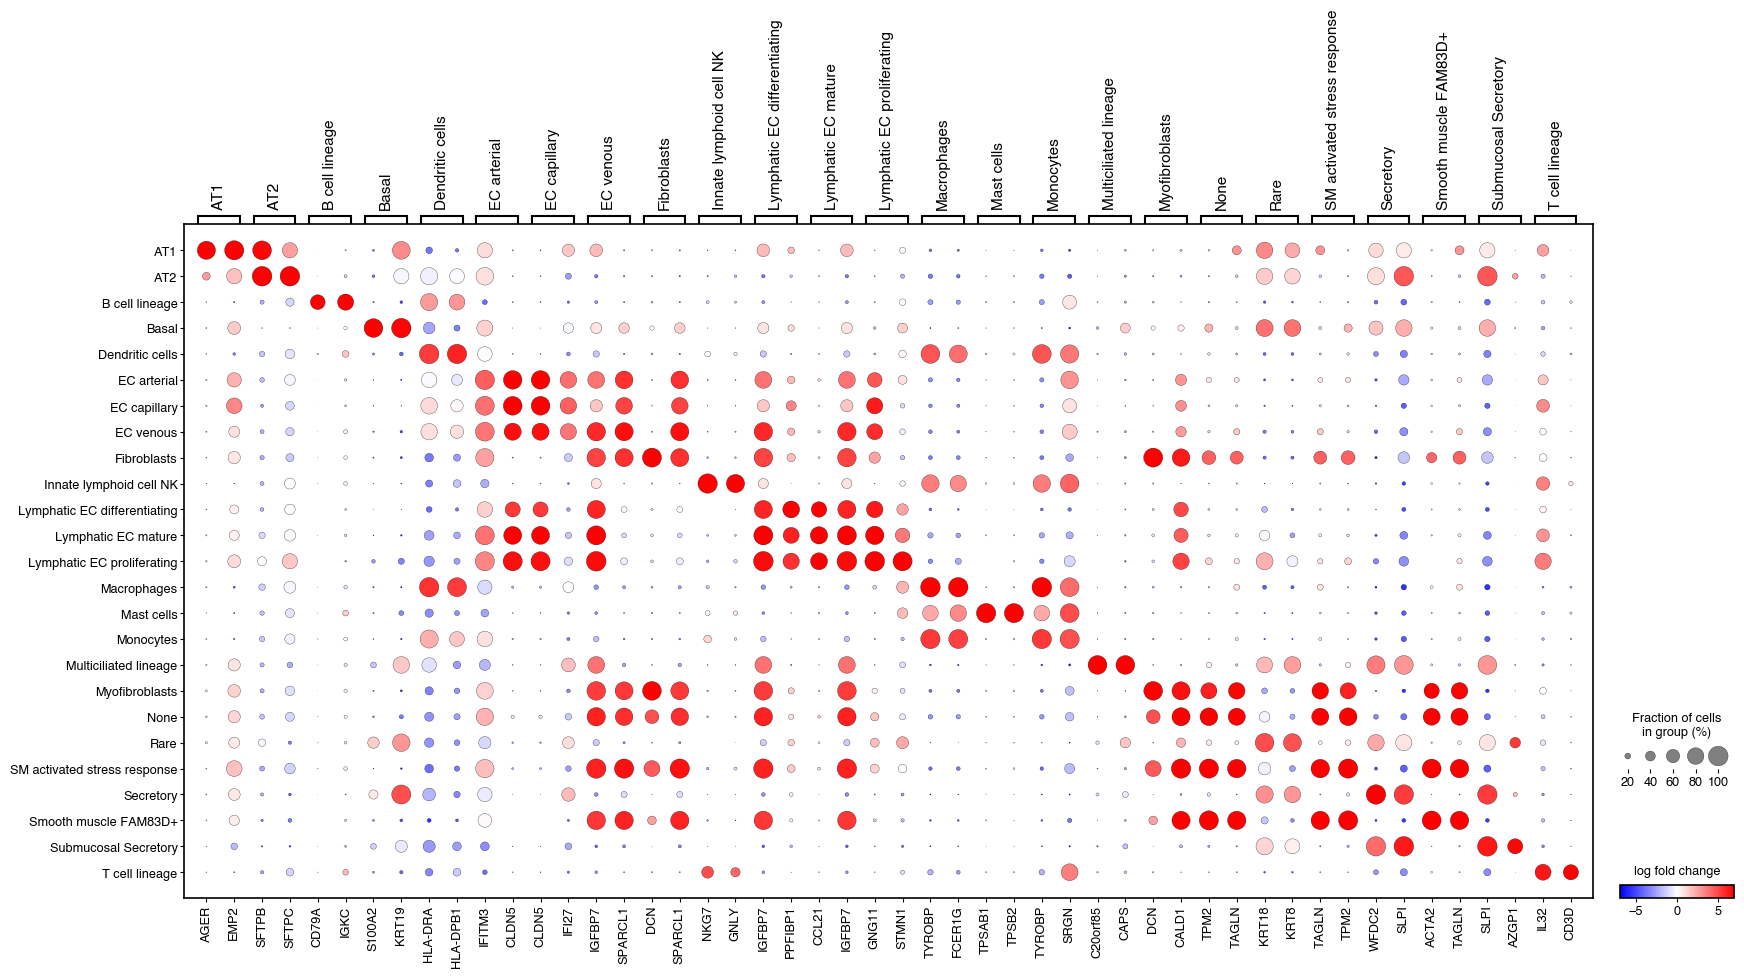

PosixPath('/Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/temp_figs/approx.svg')

In [36]:
fig_name = "approx.svg"
sc.pl.rank_genes_groups_dotplot(
    adata_approx,
    values_to_plot="logfoldchanges",
    vmax=7,
    vmin=-7,
    cmap="bwr",
    dendrogram=False,
    gene_symbols="feature_name",
    var_names=var_names,
    save=fig_name,
)

# move the figs to another directory
scanpy_fig_path = Path(f"figures/dotplot_{fig_name}").resolve()
scanpy_fig_path.replace(os.path.join(temp_fig_dir, fig_name))

For better visualization let's plot smaller LFC dotplots, subsetted to immune cell types.

/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub-clone/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


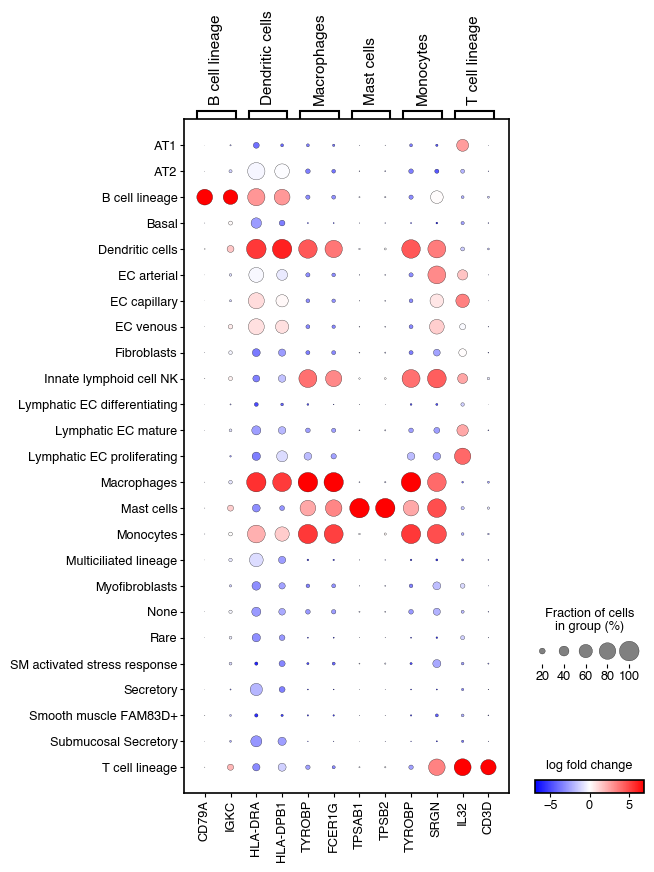

/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub-clone/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


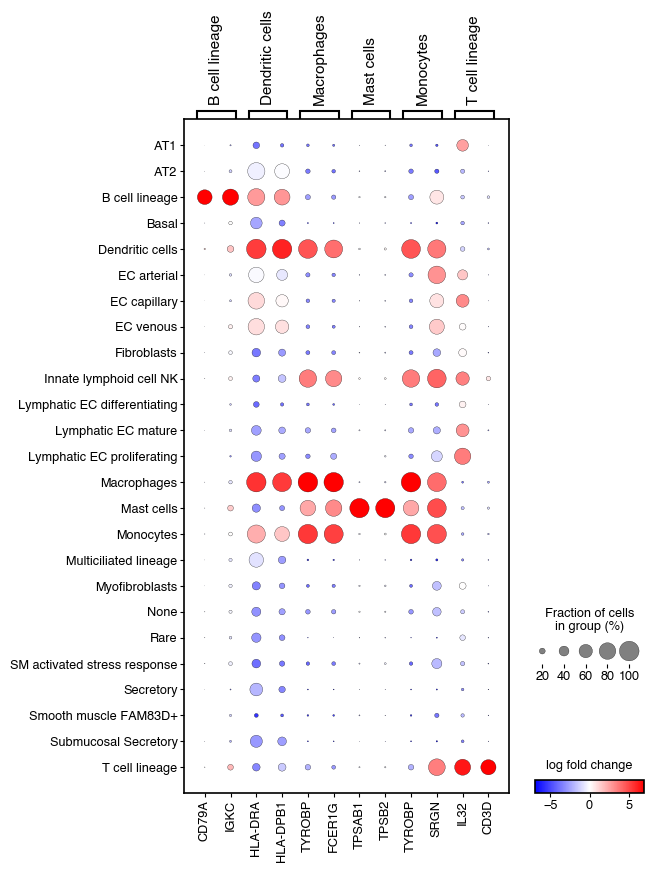

PosixPath('/Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/temp_figs/approx_subset.svg')

In [37]:
immune_types = [
    "B cell lineage",
    "Dendritic cells",
    "Macrophages",
    "Mast cells",
    "Monocytes",
    # "Neutrophilic",
    "T cell lineage"
]
var_names_subset = {k: v for k, v in var_names.items() if k in immune_types}

# raw
fig_name = "raw_subset.svg"
sc.pl.rank_genes_groups_dotplot(
    adata_de,
    values_to_plot="logfoldchanges",
    vmax=7,
    vmin=-7,
    cmap="bwr",
    dendrogram=False,
    gene_symbols="feature_name",
    var_names=var_names_subset,
    save=fig_name,
)
# move the fig to another directory
scanpy_fig_path = Path(f"figures/dotplot_{fig_name}").resolve()
scanpy_fig_path.replace(os.path.join(temp_fig_dir, fig_name))

# sampled
fig_name = "approx_subset.svg"
sc.pl.rank_genes_groups_dotplot(
    adata_approx,
    values_to_plot="logfoldchanges",
    vmax=7,
    vmin=-7,
    cmap="bwr",
    dendrogram=False,
    gene_symbols="feature_name",
    var_names=var_names_subset,
    save=fig_name,
)
# move the fig to another directory
scanpy_fig_path = Path(f"figures/dotplot_{fig_name}").resolve()
scanpy_fig_path.replace(os.path.join(temp_fig_dir, fig_name))

## 5️⃣ UMAP's

/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub-clone/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


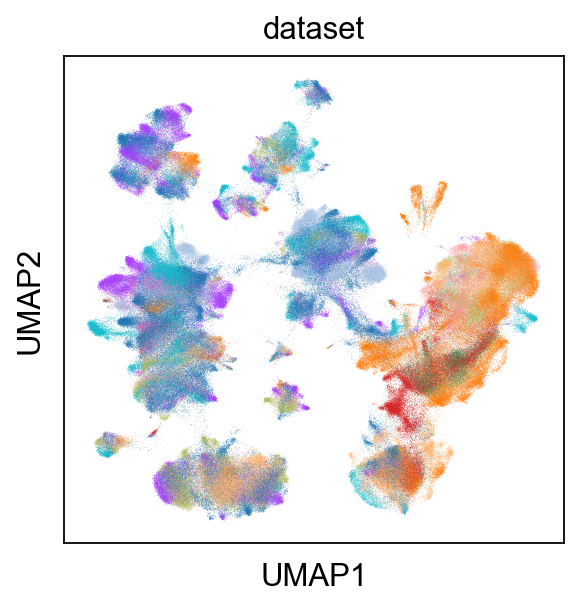

PosixPath('/Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/temp_figs/umap_dataset.svg')

In [48]:
sc.set_figure_params(vector_friendly=True, dpi_save=300, fontsize=14)
# figsize: Optional[int] = None,
# color_map: Optional[str] = None,
sc.pl.umap(
    adata,
    color=["dataset"], # dataset is the batch key
    save="_dataset.svg",
    legend_loc="left margin", # "trick" to not show the legend
    # legend_fontsize = 10,
)

# move the fig to another directory
scanpy_fig_path = Path("figures/umap_dataset.svg").resolve()
scanpy_fig_path.replace(os.path.join(temp_fig_dir, "umap_dataset.svg"))

/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub-clone/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


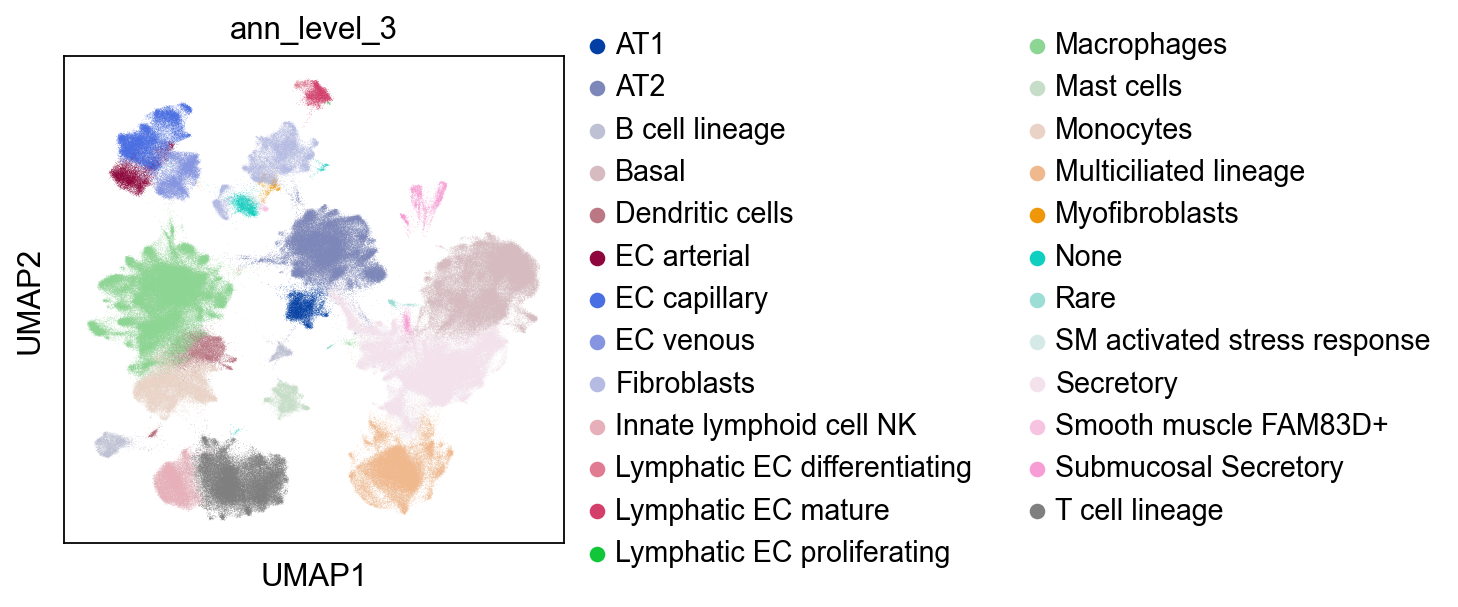

PosixPath('/Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/temp_figs/umap_label.svg')

In [56]:
sc.set_figure_params(vector_friendly=True, dpi_save=300, fontsize=14)
sc.pl.umap(
    adata,
    color=["ann_level_3"],
    save="_label.svg",
    # legend_loc="left margin", # "trick" to not show the legend
)

# move the fig to another directory
scanpy_fig_path = Path("figures/umap_label.svg").resolve()
scanpy_fig_path.replace(os.path.join(temp_fig_dir, "umap_label.svg"))